# The Battle of Neighbourhoods - Final Report

### Introduction:
##### Los Angeles County is one of the most populated countys in the United States. Due to it’s good weather, beaches and important events such as music festivals or the Oscars, and places like the Walk of Fame, the Chinese Theatre or Santa Monica boulevard, it receives thousands of tourists from all around the world. It seems to be a good place to open a restaurant or a shop.
##### This project will help people to choose the most appropiate location where a shop or a restaurant can be opened and which type of place it should be.


### Problem:
##### To find the answers to the following questions:
###### -	  Is Los Angeles a suitable place to open a store or restaurant?
###### -	  Find the most recommended type of shop or restaurant.
###### -	  Which is the best place to open a store or restaurant?
###### -	  Which is the least atractive area to open a new restaurant or store?

### Required information:
##### Database with demographic information of all the cities in the United States. Coordinates are necessary too. Economical data about citizens is helpful. Fousquare API will provide information about relevant places. 


#### Demographic information: 
##### -	Population: Low population or low density usually means low number of clients.
##### -	Ethnic groups: In case of opening a restaurant, it is uselful to know who to hire. If someone wants to open an spanish restaurant, it is usually better to hire a person that is spanish, because knows more about spanish cuisine.

#### Economical data:
##### -	Cost of living and household income: It is not a good idea to sell expensive products in places where salaries are low and the cost of living is too high.

#### Foursquare API:
##### -	It can find thousands of places (possible competitors) and provide information such as rating, number of visitors, price, categorie or location.



### Links to datasets
##### Link 1: https://simplemaps.com/data/us-cities
##### Link 2: https://data.lacounty.gov/resource/ai64-dnh8.json
##### Link 3: https://worldpopulationreview.com/state-rankings/cost-of-living-index-by-state


### Import Libraries

In [1]:
import folium
import geocoder
from geopy.geocoders import Nominatim 
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import requests
from sklearn.cluster import KMeans
from math import sin, cos, sqrt, atan2
%matplotlib inline

### Load .csv files

#### Cities, population & coordinates

In [2]:
df_cities = pd.read_csv("uscities.csv")
df_cities.columns

Index(['city', 'city_ascii', 'state_id', 'state_name', 'county_fips',
       'county_name', 'lat', 'lng', 'population', 'density', 'source',
       'military', 'incorporated', 'timezone', 'ranking', 'zips', 'id'],
      dtype='object')

In [3]:
# Drop unecessary columns
df_cities.drop(df_cities.columns.difference(["state_name", "county_name", "city", "population", "density", "lat", "lng",]), 1, inplace=True)
df_cities = df_cities[["city", "county_name", "state_name", "population", "density", "lat", "lng"]]
df_cities.head()

,city,county_name,state_name,population,density,lat,lng
0,New York,New York,New York,18713220.0,10715.0,40.6943,-73.9249
1,Los Angeles,Los Angeles,California,12750807.0,3276.0,34.1139,-118.4068
2,Chicago,Cook,Illinois,8604203.0,4574.0,41.8373,-87.6862
3,Miami,Miami-Dade,Florida,6445545.0,5019.0,25.7839,-80.2102
4,Dallas,Dallas,Texas,5743938.0,1526.0,32.7936,-96.7662


##### New York, Los Angeles, Chicago, Miami and Dallas are the mosts populated cities in the United States. The number of potential clients is highers in comparison with other cities. Los Angeles city belongs to Los Angeles County. It is interesting to have a look at the information.

###### Cities that don't belong to Los Angeles County are deleted

In [4]:
df_LAC = df_cities.drop(df_cities[(df_cities["county_name"] != "Los Angeles")].index)
df_LAC.shape

(141, 7)

In [5]:
df_LAC.head()

,city,county_name,state_name,population,density,lat,lng
1,Los Angeles,Los Angeles,California,12750807.0,3276.0,34.1139,-118.4068
93,Long Beach,Los Angeles,California,462628.0,3523.0,33.7981,-118.1675
125,Lancaster,Los Angeles,California,343304.0,645.0,34.6935,-118.1753
143,Santa Clarita,Los Angeles,California,312446.0,1162.0,34.4175,-118.4964
226,Glendale,Los Angeles,California,199303.0,2525.0,34.1818,-118.2468


#### Ethnical information

In [6]:
df_ethnic = pd.read_json("https://data.lacounty.gov/resource/ai64-dnh8.json")
df_ethnic.columns

Index(['census_tract', 'fips', 'cityname', 'service_area', 'age_0_15',
       'age_16_18', 'age_19_20', 'age_21_25', 'age_26_59', 'age_60_64',
       'age_65up', 'male', 'female', 'white', 'african_american',
       'native_american', 'asian', 'pacific_islander', 'other', 'multi_race',
       'latino'],
      dtype='object')

In [7]:
df_ethnic.drop(df_ethnic.columns.difference(['cityname','african_american','native_american', 'asian', 'pacific_islander', 'other', 'multi_race', 'latino']), 1, inplace = True)
df_ethnic = df_ethnic[['cityname','african_american','native_american', 'asian', 'pacific_islander', 'other', 'multi_race', 'latino']]
df_ethnic.head()

,cityname,african_american,native_american,asian,pacific_islander,other,multi_race,latino
0,Los Angeles city - Tujunga,73,13,515,4,34,157,1412
1,Los Angeles city - Tujunga,27,4,533,1,10,130,611
2,Los Angeles city - Tujunga,185,6,492,4,5,238,2591
3,Los Angeles city - Tujunga,36,10,286,1,4,112,1387
4,Los Angeles city - Tujunga,41,5,328,3,6,158,522


In [8]:
nPeople = df_ethnic.sum()
nPeople = pd.DataFrame(nPeople)
nPeople = nPeople.iloc[1:]
nPeople.columns = ["N_People"]
nPeople.head(10)

,N_People
african_american,326956
native_american,5897
asian,422379
pacific_islander,2922
other,13018
multi_race,75741
latino,1863578


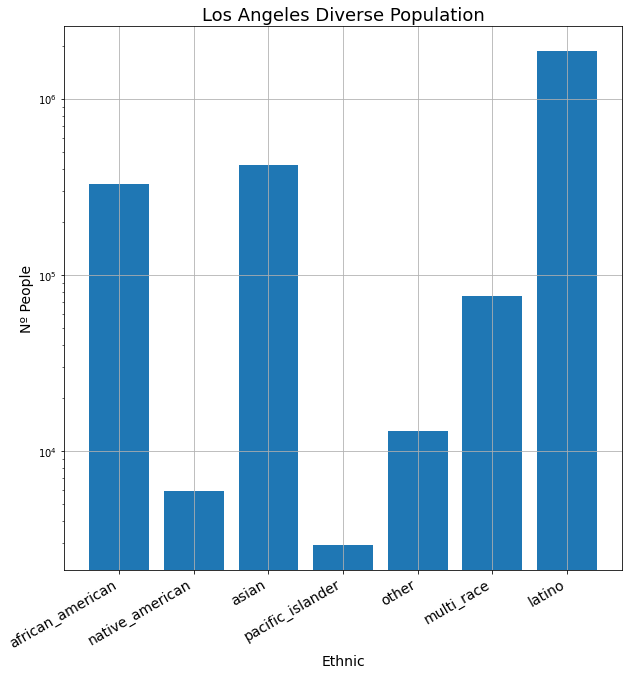

In [9]:
plt.bar(nPeople.index, nPeople["N_People"])
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.grid(True)
plt.xticks(rotation = 30, ha = 'right', fontsize = 14);
plt.ylabel("Nº People", fontsize = 14)
plt.xlabel("Ethnic", fontsize = 14)
plt.title("Los Angeles Diverse Population", fontsize = 18)
fig.savefig('ethnicsLA.png', dpi = 200)
plt.yscale('log')
plt.show()

##### The number of latinos is enormous in comparison with other ethnics. This information is very useful. If a person wants to open a mexican, colombian or cuban restaurant (for example) it will be easier to hire someone who knows more about mexican, colombian or cuban cuisine.

#### Economical information
##### The ratio between Household Income and the Cost of Living is calculated. This will help us to know if it is better to offer expensive or cheap products.

In [10]:
df_cost = pd.read_csv("cost_of_living.csv")
df_cost.columns

Index(['State', 'costIndex', 'costRank', 'groceryCost', 'housingCost',
       'utilitiesCost', 'transportationCost', 'miscCost'],
      dtype='object')

In [11]:
df_cost = df_cost.sort_values(by = ["State"])
df_cost.reset_index(inplace = True, drop=True)
df_cost.drop(df_cost.columns.difference(["State", "costIndex"]), 1, inplace = True)
df_cost.columns = ["State", "Cost_Index"]

In [12]:
df_income = pd.read_csv("income.csv")
df_income = df_income.drop(df_income[(df_income["State"] == "Puerto Rico") | (df_income[("State")] == "Washington DC")].index)
df_income = df_income.sort_values(by = ["State"])
df_income.reset_index(inplace = True, drop=True)
df_income.drop("State", axis = 1, inplace = True)
df_income.columns = ["Household_Income"]

In [13]:
ratio = pd.DataFrame(df_income["Household_Income"] / df_cost["Cost_Index"])
ratio.columns = ["Ratio"]
df_ratio = pd.concat([df_cost, df_income, ratio], axis = 1)
df_ratio.head()

,State,Cost_Index,Household_Income,Ratio
0,Alabama,89.3,48486,542.956327
1,Alaska,129.9,76715,590.569669
2,Arizona,97.0,56213,579.515464
3,Arkansas,86.9,45726,526.191024
4,California,151.7,71228,469.531971


In [14]:
df_ratio = df_ratio.sort_values(by = ["Ratio"], ascending = True)
df_ratio.reset_index(inplace = True, drop=True)
df_ratio.head(10)

,State,Cost_Index,Household_Income,Ratio
0,Hawaii,192.9,78084,404.790047
1,Oregon,134.2,59393,442.570790
2,California,151.7,71228,469.531971
3,New York,139.1,65323,469.611790
4,Maine,117.5,55425,471.702128
5,Montana,106.9,52559,491.665108
6,West Virginia,91.1,44921,493.095499
7,Mississippi,86.1,43567,506.004646
8,Louisiana,93.9,47942,510.564430
9,Vermont,114.5,60076,524.681223


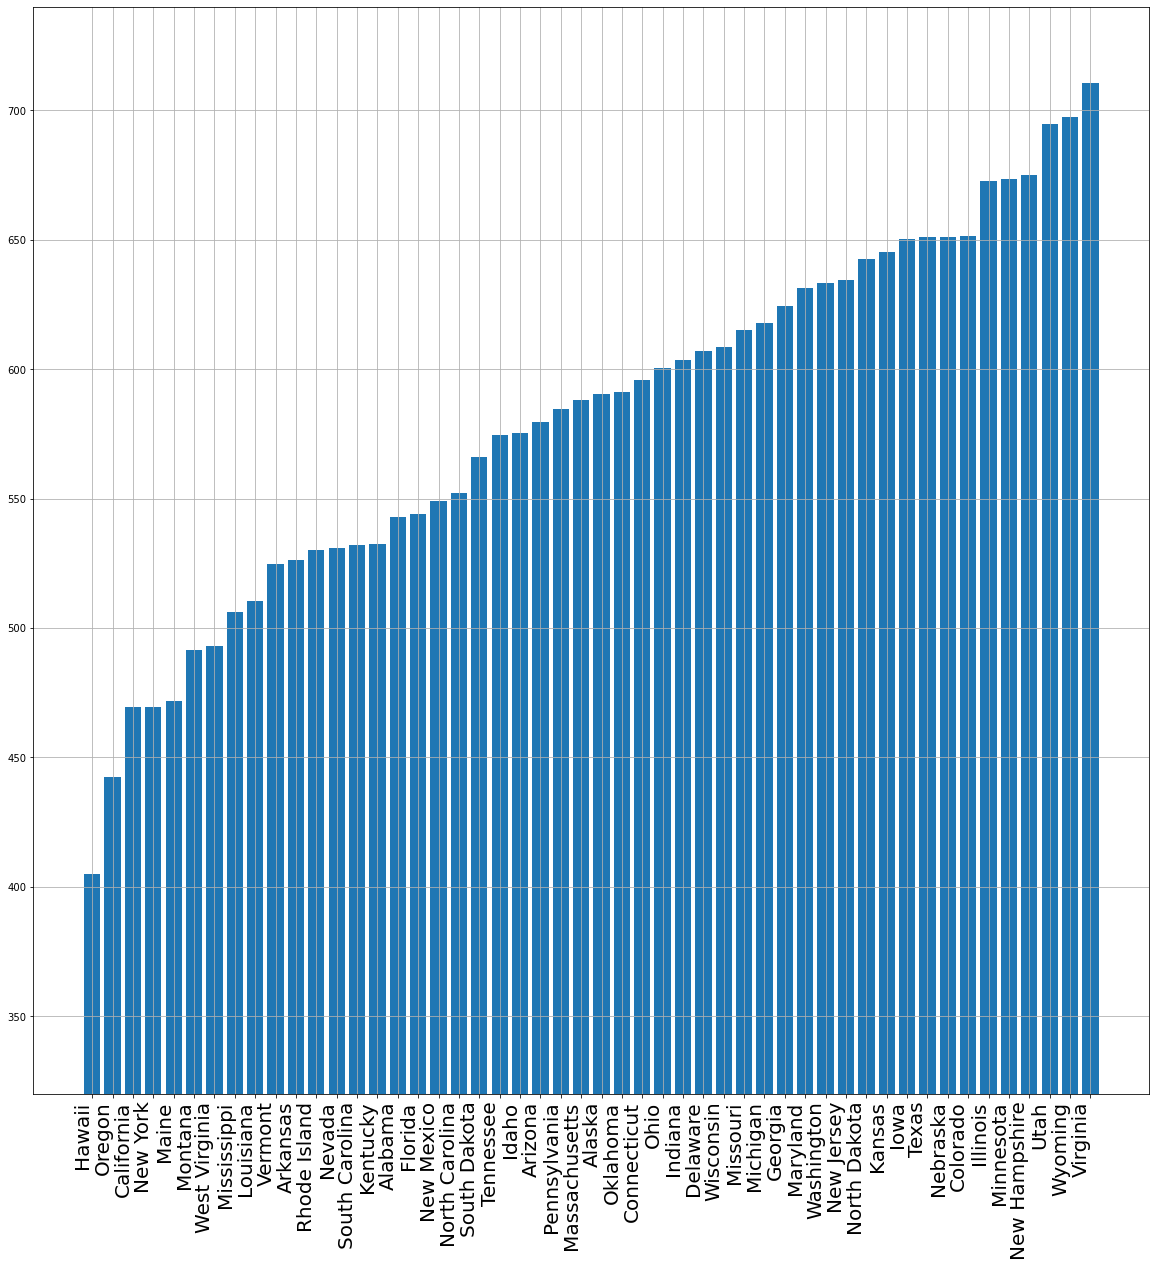

In [15]:
plt.bar(df_ratio["State"], df_ratio["Ratio"])
fig = plt.gcf()
fig.set_size_inches(20, 20)
fig.savefig('ratio.png', dpi = 200)
plt.grid(True)
plt.ylim(ymin = 320, ymax = 740)
plt.xticks(rotation = 90, ha = 'right', fontsize = 20);

##### California's Household Income / Cost of Living ratio is not too high. This means that it is better to offer cheaper products.

### Filtering cities

#### df_LAC contains information about 141 cities. It must be reduced.

In [16]:
df_LAC.head()

,city,county_name,state_name,population,density,lat,lng
1,Los Angeles,Los Angeles,California,12750807.0,3276.0,34.1139,-118.4068
93,Long Beach,Los Angeles,California,462628.0,3523.0,33.7981,-118.1675
125,Lancaster,Los Angeles,California,343304.0,645.0,34.6935,-118.1753
143,Santa Clarita,Los Angeles,California,312446.0,1162.0,34.4175,-118.4964
226,Glendale,Los Angeles,California,199303.0,2525.0,34.1818,-118.2468


In [141]:
df_LAC.shape

(141, 7)

###### There are 9 cities wich population is over the average

In [17]:
avgPop = df_LAC["population"].mean()
dfPop = df_LAC.drop(df_LAC[(df_LAC["population"] < avgPop)].index);
dfPop.shape

(9, 7)

In [18]:
dfPop.head(9)

,city,county_name,state_name,population,density,lat,lng
1,Los Angeles,Los Angeles,California,12750807.0,3276.0,34.1139,-118.4068
93,Long Beach,Los Angeles,California,462628.0,3523.0,33.7981,-118.1675
125,Lancaster,Los Angeles,California,343304.0,645.0,34.6935,-118.1753
143,Santa Clarita,Los Angeles,California,312446.0,1162.0,34.4175,-118.4964
226,Glendale,Los Angeles,California,199303.0,2525.0,34.1818,-118.2468
284,Palmdale,Los Angeles,California,155079.0,564.0,34.5944,-118.1057
293,Pomona,Los Angeles,California,151691.0,2548.0,34.0585,-117.7626
309,Torrance,Los Angeles,California,143592.0,2701.0,33.8346,-118.3417
318,Pasadena,Los Angeles,California,141029.0,2371.0,34.1597,-118.1390


###### There are 65 cities wich density is over the average density

In [19]:
avgDen = df_LAC["density"].mean()
dfDen = df_LAC.drop(df_LAC[(df_LAC["density"] < avgDen)].index);
dfDen.shape

(65, 7)

In [20]:
dfDen.head(9)

,city,county_name,state_name,population,density,lat,lng
1,Los Angeles,Los Angeles,California,12750807.0,3276.0,34.1139,-118.4068
93,Long Beach,Los Angeles,California,462628.0,3523.0,33.7981,-118.1675
366,East Los Angeles,Los Angeles,California,119827.0,6212.0,34.0326,-118.1691
389,El Monte,Los Angeles,California,115487.0,4663.0,34.0739,-118.0291
407,Downey,Los Angeles,California,111126.0,3457.0,33.9379,-118.1312
425,Inglewood,Los Angeles,California,108151.0,4604.0,33.9566,-118.3444
440,Norwalk,Los Angeles,California,103949.0,4133.0,33.9069,-118.0829
479,Compton,Los Angeles,California,95605.0,3680.0,33.8930,-118.2275
495,South Gate,Los Angeles,California,93444.0,4985.0,33.9448,-118.1926


### Los Angeles County Map

##### A map with all cities is displayed. The distance between the most populated cities and the cities which density is above the average is calculated. If the distance between a most populated city and another city is greater than a threshold, it will be deleted.

##### Coordinates

In [21]:
geolocator = Nominatim(user_agent = "toronto_explorer")
location = geolocator.geocode("Los Angeles, United States")
latitude = location.latitude
longitude = location.longitude
print("United States coordinates : \nLatitude : ", latitude, "\nLongitude: ", longitude)

United States coordinates : 
Latitude :  34.0536909 
Longitude:  -118.2427666


#### Map

In [22]:
###### RED   -> Most populated cities
###### GREEN -> Cities wich density is above the average
###### BLUE  -> Rest of the cities

In [23]:
map_LAC = folium.Map(location = [latitude, longitude], zoom_start = 9)

for lat, lng, z, state_name in zip(df_LAC["lat"], df_LAC["lng"], df_LAC["county_name"], df_LAC["city"]):
    label = '{}, {}'.format(state_name, z)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker([lat, lng], radius = 5, popup = label, color = "blue", fill=True, fill_color = "#3186cc", fill_opacity = 0.5).add_to(map_LAC)

for lat, lng, z, state_name in zip(dfDen["lat"], dfDen["lng"], dfDen["county_name"], dfDen["city"]):
    label = '{}, {}'.format(state_name, z)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker([lat, lng], radius = 5, popup = label, color = "green", fill=True, fill_color = "#3186cc", fill_opacity = 0.5).add_to(map_LAC) 
    
for lat, lng, z, state_name in zip(dfPop["lat"], dfPop["lng"], dfPop["county_name"], dfPop["city"]):
    label = '{}, {}'.format(state_name, z)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker([lat, lng], radius = 5, popup = label, color = "red", fill=True, fill_color = "#3186cc", fill_opacity = 0.5).add_to(map_LAC)
    
map_LAC

###### If distance is greater than 500 meters, the city is deleted.

In [24]:
nearbyC = []
R = 6373.0
for i, j, k in zip(dfPop["lat"], dfPop["lng"], dfPop["city"]):
    for m, n, o in zip(dfDen["lat"], dfDen["lng"], dfDen["city"]):
        dlon = j - n
        dlat = i - m
        a = (sin(dlat / 2)) ** 2 + cos(m) * cos(i) * (sin(dlon / 2)) ** 2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c
        if (distance <= 500 and distance != 0):
            nearbyC.append(o)
nearbyCities = pd.DataFrame(nearbyC)
nearbyCities.columns =  ["Nearby Cities"]
nearbyCities.shape

(15, 1)

##### We have now 9 + 15 = 24 cities

In [25]:
nearbyCities = df_LAC.drop(df_LAC[(df_LAC["city"] != "West Hollywood") & (df_LAC["city"] != "Lakewood") & (df_LAC["city"] != "Lakewood")
                             & (df_LAC["city"] != "Hawaiian Gardens") & (df_LAC["city"] != "Redondo Beach") & (df_LAC["city"] != "Gardena")
                             & (df_LAC["city"] != "Manhattan Beach") & (df_LAC["city"] != "Lawndale") & (df_LAC["city"] != "West Carson")
                             & (df_LAC["city"] != "Lomita") & (df_LAC["city"] != "Hermosa Beach") & (df_LAC["city"] != "Alhambra")
                             & (df_LAC["city"] != "San Gabriel") & (df_LAC["city"] != "South Pasadena") & (df_LAC["city"] != "East San Gabriel")
                             & (df_LAC["city"] != "San Pasqual")].index)
nearbyCities.shape

(15, 7)

In [26]:
goodCities = pd.concat([dfPop, nearbyCities])
goodCities.shape

(24, 7)

In [142]:
goodCities.head(24)

,city,county_name,state_name,population,density,lat,lng
1,Los Angeles,Los Angeles,California,12750807.0,3276.0,34.1139,-118.4068
93,Long Beach,Los Angeles,California,462628.0,3523.0,33.7981,-118.1675
125,Lancaster,Los Angeles,California,343304.0,645.0,34.6935,-118.1753
143,Santa Clarita,Los Angeles,California,312446.0,1162.0,34.4175,-118.4964
226,Glendale,Los Angeles,California,199303.0,2525.0,34.1818,-118.2468
284,Palmdale,Los Angeles,California,155079.0,564.0,34.5944,-118.1057
293,Pomona,Los Angeles,California,151691.0,2548.0,34.0585,-117.7626
309,Torrance,Los Angeles,California,143592.0,2701.0,33.8346,-118.3417
318,Pasadena,Los Angeles,California,141029.0,2371.0,34.1597,-118.1390
557,Alhambra,Los Angeles,California,83750.0,4237.0,34.0840,-118.1355


In [27]:
goodCities.columns

Index(['city', 'county_name', 'state_name', 'population', 'density', 'lat',
       'lng'],
      dtype='object')

### Good Cities Map

In [28]:
map_GC = folium.Map(location = [latitude, longitude], zoom_start = 9)

for lat, lng, z, state_name in zip(goodCities["lat"], goodCities["lng"], goodCities["county_name"], goodCities["city"]):
    label = '{}, {}'.format(state_name, z)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker([lat, lng], radius = 5, popup = label, color = "blue", fill=True, fill_color = "#3186cc", fill_opacity = 0.5).add_to(map_GC)

for lat, lng, z, state_name in zip(dfPop["lat"], dfPop["lng"], dfPop["county_name"], dfPop["city"]):
    label = '{}, {}'.format(state_name, z)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker([lat, lng], radius = 5, popup = label, color = "green", fill=True, fill_color = "#3186cc", fill_opacity = 0.5).add_to(map_GC) 

map_GC

### Finding Venues

##### The number of cities is much lower now. It is time to search venues. This will help us to decide which are the most popular places and our possible competitors

#### Foursquare

In [29]:
CLIENT_ID = 'WHPSQQBOBNRZZOP4CJBMLOSPV5PGE2AUXTSRJNE4GSPXPLGP' # your Foursquare ID
CLIENT_SECRET = 'SSTNCNUPXLSQI4HUCV43LEYP0KGTSMOQEN2RSLEN5TE2UJ3L' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WHPSQQBOBNRZZOP4CJBMLOSPV5PGE2AUXTSRJNE4GSPXPLGP
CLIENT_SECRET:SSTNCNUPXLSQI4HUCV43LEYP0KGTSMOQEN2RSLEN5TE2UJ3L


#### Venues

##### Create a new dataframe with the coordinates of the "Good Cities"

In [30]:
coords = df_ratio = pd.concat([goodCities["city"], goodCities["county_name"], goodCities["lat"], goodCities["lng"]], axis = 1)
coords.columns

Index(['city', 'county_name', 'lat', 'lng'], dtype='object')

In [31]:
coords.shape

(24, 4)

In [32]:
coords.reset_index(inplace = True, drop = True)
coords.head()

,city,county_name,lat,lng
0,Los Angeles,Los Angeles,34.1139,-118.4068
1,Long Beach,Los Angeles,33.7981,-118.1675
2,Lancaster,Los Angeles,34.6935,-118.1753
3,Santa Clarita,Los Angeles,34.4175,-118.4964
4,Glendale,Los Angeles,34.1818,-118.2468


#### Study number of stores and restaurants.

In [33]:
def nearbyVenues(names, latitudes, longitudes, radius, LIMIT): 
    venList = []
    for name, lat, lng in zip(names, latitudes, longitudes):   

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        aux = requests.get(url).json()["response"]['groups'][0]['items']
        
        venList.append([(name, lat, lng, v["venue"]["name"], v["venue"]["location"]["lat"], 
            v["venue"]["location"]["lng"], v['venue']['categories'][0]['id'], v["venue"]["categories"][0]["name"]) for v in aux])
        
    nearVenues = pd.DataFrame([item for venList in venList for item in venList])
    nearVenues.columns = ["City", "C_Lat", "C_Lng", "Venue", "V_Lat", "V_Lng", "Venue_ID", "V_Cat"]   
    return(nearVenues)

In [34]:
venues = nearbyVenues(names = goodCities["city"], latitudes = goodCities["lat"], longitudes = goodCities["lng"], radius = 2000, LIMIT = 1000)
venues.to_csv("venues.csv")

In [35]:
venues.columns

Index(['City', 'C_Lat', 'C_Lng', 'Venue', 'V_Lat', 'V_Lng', 'Venue_ID',
       'V_Cat'],
      dtype='object')

##### Foursquare API provides information about 2040 venues.

In [36]:
venues.shape

(2040, 8)

##### Let's study the number of venues per categorie

In [37]:
nVenues = venues.pivot_table(index=['V_Cat'], aggfunc='size')
nVenues = nVenues.sort_values(ascending = False)
nVenues = pd.DataFrame({"V_Cat": nVenues.index, "N_Venues": nVenues.values})
#nVenues = nVenues.head(10)
nVenues.to_csv("nVenues.csv")

In [38]:
topCatVenues = nVenues.head(15)
#topCatVenues.head(15)

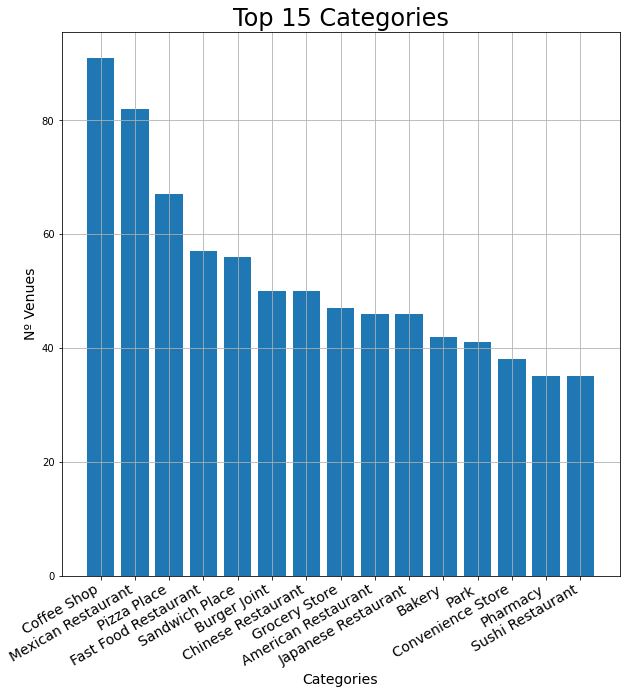

In [137]:
plt.bar(topCatVenues["V_Cat"], topCatVenues["N_Venues"])
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.grid(True)
plt.xticks(rotation = 30, ha = 'right', fontsize = 14);
plt.ylabel("Nº Venues", fontsize = 14)
plt.xlabel("Categories", fontsize = 14)
plt.title("Top 15 Categories", fontsize = 24)
fig.savefig('number_of_venues.png', dpi = 200)

###### Coffee Shops, Mexican Restaurants and Pizza Places are very popular in Los Angeles.

##### Which is the number of restaurants per city?

In [40]:
mexVen = venues.drop(venues[(venues["V_Cat"] != "Mexican Restaurant")].index)
mexVen.to_csv("mexVenues.csv")
mexVen.columns

Index(['City', 'C_Lat', 'C_Lng', 'Venue', 'V_Lat', 'V_Lng', 'Venue_ID',
       'V_Cat'],
      dtype='object')

In [45]:
mexVen.shape

(82, 8)

In [46]:
nMex = mexVen.pivot_table(index=["City"], aggfunc = "size")
nMex = pd.DataFrame({"City": nMex.index, "N_Restaurants": nMex.values})
nMex = nMex.sort_values(by = "N_Restaurants", ascending = False)
#nMex.head(10)

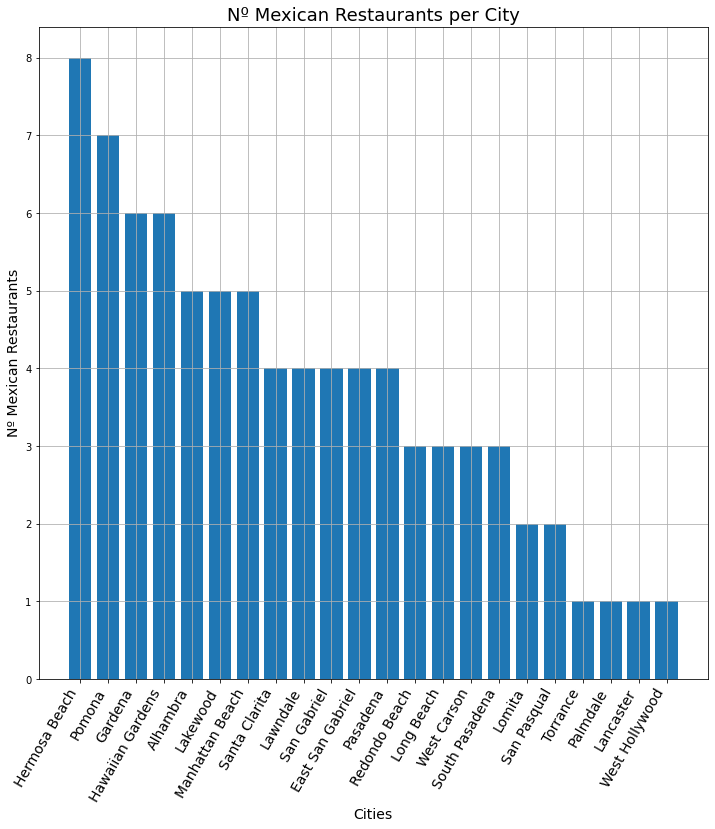

In [138]:
plt.bar(nMex["City"], nMex["N_Restaurants"])
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.grid(True)
plt.xticks(rotation = 60, ha = 'right', fontsize = 14);
plt.ylabel("Nº Mexican Restaurants", fontsize = 14)
plt.xlabel("Cities", fontsize = 14)
plt.title("Nº Mexican Restaurants per City", fontsize = 18)
fig.savefig('number_of_mex', dpi = 200)

#### Details of Mexican Restaurants

In [68]:
# get_venues(lat,lng) -> Returns location and ID number of mexican restaurants

In [69]:
# get_venue_details(venue_id) -> Returns number of likes, ratings and tips.

In [70]:
def get_venues(lat,lng):

    CLIENT_ID = '54TITIEDYACLVWVPEUTUFCMIFR4WU0EXEVCJVTFDVEAAGHQ4' # your Foursquare ID
    CLIENT_SECRET = 'RS3YWTYKH2JIKM0G2ZYMI1EZEKJLHM0ALMOUYV1EURDGAGA3' # your Foursquare Secret
    VERSION = '20180604'
    radius = 2000
    LIMIT = 1000
    
    # Foursquare API url
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
    
    # Get  Data
    results = requests.get(url).json()
    venue_data = results["response"]['groups'][0]['items']
    venue_details = []
    for row in venue_data:
        try:
            venue_id = row['venue']['id']
            venue_name = row['venue']['name']
            venue_category = row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names = ['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns = column_names)
    return df

In [71]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '54TITIEDYACLVWVPEUTUFCMIFR4WU0EXEVCJVTFDVEAAGHQ4' # your Foursquare ID
    CLIENT_SECRET = 'RS3YWTYKH2JIKM0G2ZYMI1EZEKJLHM0ALMOUYV1EURDGAGA3' # your Foursquare Secret
    VERSION = '20180604'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id = venue_data['id']
        venue_name = venue_data['name']
        venue_likes = venue_data['likes']['count']
        venue_rating = venue_data['rating']
        venue_tips = venue_data['tips']['count']
        venue_details.append([venue_id, venue_name, venue_likes, venue_rating, venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [72]:
mexRest = pd.DataFrame(columns = ['City', 'County_Name', 'ID','Name'])
count = 1
for row in coords.values.tolist():
    city, county_name, Latitude, Longitude = row
    venues = get_venues(Latitude,Longitude)
    mexican = venues[venues['Category'] == 'Mexican Restaurant']   
    for resturant_detail in mexican.values.tolist():
        id, name , category = resturant_detail
        mexRest = mexRest.append({'City': city,'County_Name': county_name, 'ID': id, 'Name' : name}, ignore_index = True)
    count += 1

In [73]:
mexRest.columns
mexRest.to_csv("mexican_restaurants.csv")

In [74]:
mexRest.shape

(82, 4)

In [75]:
mexStats = pd.DataFrame(columns = ['City', 'County_Name', 'ID','Name','Likes','Rating','Tips'])
count = 1

for row in mexRest.values.tolist():
    City , County_name, ID, Name = row
    try:
        venue_details = get_venue_details(ID)
        print(venue_details)
        id, name, likes, rating, tips = venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id = ',ID)
        # we will assign 0 value for these resturants as they may have been 
        # recently opened or details does not exist in FourSquare Database
        id, name, likes, rating, tips = [0] * 5
    print('(',count,'/',len(mexRest),')','processed')
    mexStats = mexStats.append({'City': City,'County_Name': County_name, 'ID': id, 'Name' : name,
                                'Likes' : likes, 'Rating' : rating, 'Tips' : tips}, ignore_index = True)
    count += 1

                         ID     Name  Likes  Rating  Tips
0  4ca069322fb1a1438cdefb40  El Sauz     18     8.1     7
( 1 / 82 ) processed
                         ID       Name  Likes  Rating  Tips
0  4bd8a2ddf645c9b68e8fa8e0  La Concha      7     7.7     6
( 2 / 82 ) processed
                         ID                    Name  Likes  Rating  Tips
0  548a3fea498e4644688b91c0  Chipotle Mexican Grill     18     7.8     1
( 3 / 82 ) processed
                         ID          Name  Likes  Rating  Tips
0  4c9fc4df7c096dcbc484e1d1  Pepe el Toro      8     7.7     3
( 4 / 82 ) processed
                         ID                             Name  Likes  Rating  \
0  4bc13d3ab492d13a87daa560  Maria Bonita Mexican Restaurant     15     7.1   

   Tips  
0     5  
( 5 / 82 ) processed
                         ID          Name  Likes  Rating  Tips
0  4e8c8fd1f5b91e225589fde5  Las Delicias      9     7.2     3
( 6 / 82 ) processed
                         ID                        Name  Like

In [95]:
mexStats.to_csv("mexStats.csv", index = False)
mexStats.head()

Index(['Unnamed: 0', 'City', 'County_Name', 'ID', 'Name', 'Likes', 'Rating',
       'Tips'],
      dtype='object')

In [143]:
mexStats = pd.read_csv("mexStats.csv")
mexStats.head(10)

,City,County_Name,ID,Name,Likes,Rating,Tips
0,Long Beach,Los Angeles,4ca069322fb1a1438cdefb40,El Sauz,18,8.1,7
1,Long Beach,Los Angeles,4bd8a2ddf645c9b68e8fa8e0,La Concha,7,7.7,6
2,Long Beach,Los Angeles,548a3fea498e4644688b91c0,Chipotle Mexican Grill,18,7.8,1
3,Lancaster,Los Angeles,4c9fc4df7c096dcbc484e1d1,Pepe el Toro,8,7.7,3
4,Santa Clarita,Los Angeles,4bc13d3ab492d13a87daa560,Maria Bonita Mexican Restaurant,15,7.1,5
5,Santa Clarita,Los Angeles,4e8c8fd1f5b91e225589fde5,Las Delicias,9,7.2,3
6,Santa Clarita,Los Angeles,573e9220498ebf62bb0b783c,Dario's Mexican Restaurant,7,7.6,1
7,Palmdale,Los Angeles,4b7f170af964a520b01530e3,Mi Ranchito,3,6.9,7
8,Pomona,Los Angeles,4b8db81df964a5206d0a33e3,Tijuana's Tacos,23,7.8,10
9,Pomona,Los Angeles,4bcfb587462cb713b655d707,Mexico Lindo,12,8.4,5


##### Mexican Restaurants with maximum Likes, Ratings & Tips

In [86]:
mexStats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   City         82 non-null     object 
 1   County_Name  82 non-null     object 
 2   ID           82 non-null     object 
 3   Name         82 non-null     object 
 4   Likes        82 non-null     object 
 5   Rating       82 non-null     float64
 6   Tips         82 non-null     object 
dtypes: float64(1), object(6)
memory usage: 4.6+ KB


In [87]:
###### Convert Likes and tips to float values
mexStats['Likes'] = mexStats['Likes'].astype('float64')
mexStats['Tips'] = mexStats['Tips'].astype('float64')

In [88]:
mexStats.iloc[mexStats['Likes'].idxmax()]

City                      Hermosa Beach
County_Name                 Los Angeles
ID             432a0b00f964a520d4271fe3
Name                      Baja Sharkeez
Likes                               146
Rating                              7.4
Tips                                 86
Name: 66, dtype: object

In [89]:
mexStats.iloc[mexStats['Rating'].idxmax()]

City                             Lawndale
County_Name                   Los Angeles
ID               54e25c0d498ee09006277d04
Name           Baja California Fish Tacos
Likes                                  76
Rating                                9.1
Tips                                   18
Name: 52, dtype: object

In [99]:
mexStats.iloc[mexStats['Tips'].idxmax()]

Unnamed: 0                           66
City                      Hermosa Beach
County_Name                 Los Angeles
ID             432a0b00f964a520d4271fe3
Name                      Baja Sharkeez
Likes                               146
Rating                              7.4
Tips                                 86
Name: 66, dtype: object

In [127]:
mexGroupCity = mexStats.groupby("City", as_index = False).mean()[["City", "Rating"]]
mexGroupCity.columns = ["City", "Average Rating"];
mexGroupCity = mexGroupCity.sort_values(by = "Average Rating", ascending = False);

In [144]:
mexGroupCity.reset_index(inplace = True, drop = True)
mexGroupCity.head(10)

,City,Average Rating
0,West Hollywood,8.600000
1,Redondo Beach,8.366667
2,Torrance,8.300000
3,Lawndale,8.250000
4,Hermosa Beach,8.237500
5,Manhattan Beach,8.220000
6,Lomita,7.900000
7,Long Beach,7.866667
8,Alhambra,7.760000
9,Lancaster,7.700000


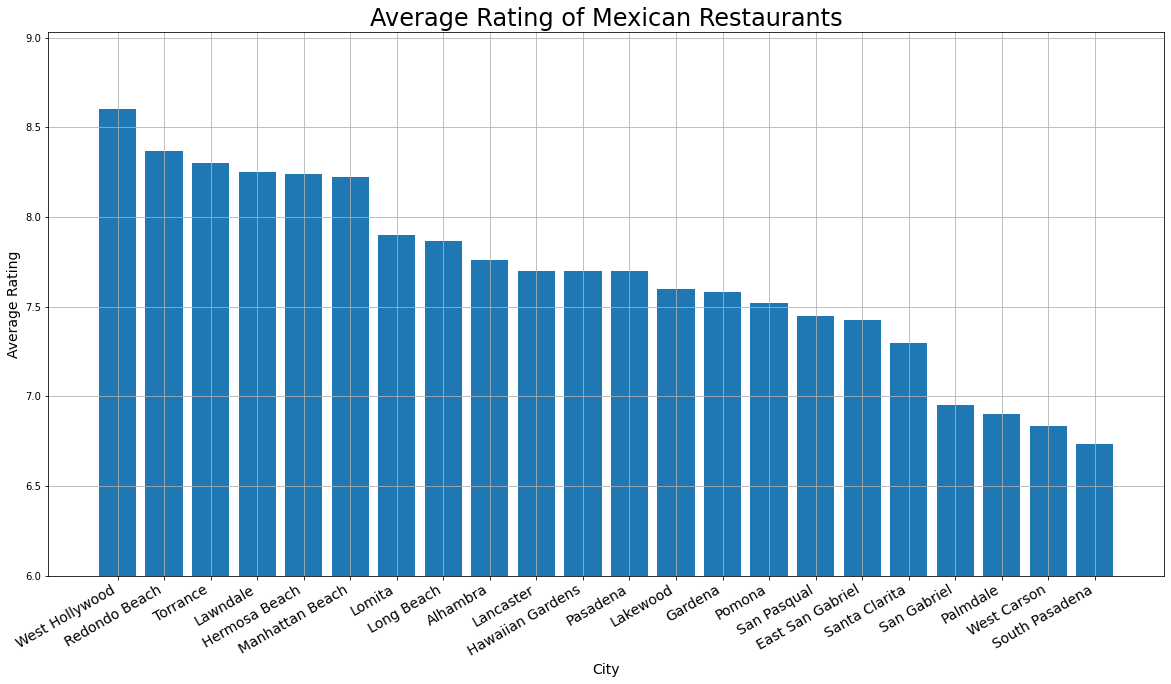

In [136]:
plt.bar(mexGroupCity["City"], mexGroupCity["Average Rating"])
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.grid(True)
plt.xticks(rotation = 30, ha = 'right', fontsize = 14);
plt.ylabel("Average Rating", fontsize = 14)
plt.xlabel("City", fontsize = 14)
plt.title("Average Rating of Mexican Restaurants", fontsize = 24)
plt.ylim(ymin = 6)
fig.savefig('avg_Rating.png', dpi = 200)

In [146]:
map_MX = folium.Map(location = [latitude, longitude], zoom_start = 9)

for lat, lng, z, state_name in zip(goodCities["lat"], goodCities["lng"], goodCities["county_name"], goodCities["city"]):
    label = '{}, {}'.format(state_name, z)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker([lat, lng], radius = 5, popup = label, color = "blue", fill=True, fill_color = "#3186cc", fill_opacity = 0.5).add_to(map_MX)

for lat, lng, z, state_name in zip(dfPop["lat"], dfPop["lng"], dfPop["county_name"], dfPop["city"]):
    label = '{}, {}'.format(state_name, z)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker([lat, lng], radius = 5, popup = label, color = "green", fill=True, fill_color = "#3186cc", fill_opacity = 0.5).add_to(map_MX)  

for lt, lg, ven_name in zip(mexVen["V_Lat"], mexVen["V_Lng"], mexVen["Venue"]):
    label = '{}'.format(ven_name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker([lt, lg], radius = 5, popup = label, color = "red", fill=True, fill_color = "#d46666", fill_opacity = 0.5).add_to(map_MX)        
map_MX